In [2]:
import time
from collections import deque

import os

os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import gym
import logging
from arguments import get_args
from config_init import get_config_init
#from utils.storage import GlobalRolloutStorage, FIFOMemory
#from utils.optimization import get_optimizer
from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
from util import AgentPositionSensor,draw_top_down_map,inverse_transform,make_train_data,RewardForwardFilter,RunningMeanStd,global_grad_norm_

#from ppo import PPO

import sys
import matplotlib

if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

In [3]:
argumnts = ''
args = get_args(argumnts)
config = get_config_init()

Auto GPU config:
Number of processes: 36
Number of processes on GPU 0: 0
Number of processes per GPU: 12


In [4]:
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
args.num_processes = 3
num_scenes = args.num_processes
num_episodes = int(args.num_episodes)

In [5]:
from my_env import MyRLEnvNew

In [6]:
rank = range(args.num_processes)
dataset = PointNavDatasetV1(config.TASK_CONFIG.DATASET)
one_env = MyRLEnvNew(args=args, rank=rank, config=config, dataset=dataset)

2020-04-17 20:24:15,726 initializing sim Sim-v0
2020-04-17 20:24:19,984 Initializing task Nav-v0


In [7]:
obs = one_env.reset()

2020-04-17 20:24:23,149 Computing map for /data/gibson/Mosquito.glb
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch-1.4.0-py3.6-linux-x86_64.egg/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch-1.4.0-py3.6-linux-x86_64.egg/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


(2.0051, -0.62133, -0.8688985694598834)
[240.0, 240.0, 0.0]


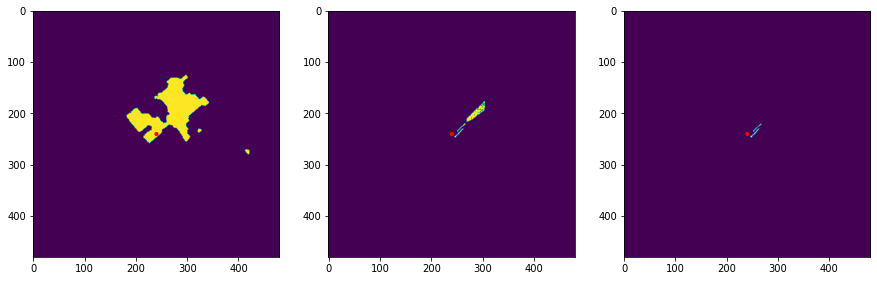

In [8]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
circ = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[0]/10*2),3,color='red')
circ2 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[0]/10*2),3,color='red')
circ3 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[0]/10*2),3,color='red')
ax.imshow(one_env.explorable_map)
ax.add_patch(circ)
ax2.imshow(one_env.explored_map)
ax2.add_patch(circ2)
ax3.imshow(one_env.map)
ax3.add_patch(circ3)
print(one_env.last_sim_location)
print([one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2,one_env.mapper_gt_pose[2]])

In [50]:
obs, reward, done, info = one_env.step(action=1)

0.25000273440592513 4.5144721060358967e-07 0.0


(2.2753413, -2.435102, -0.8688996014462766)
[271.1903110828123, 220.70533326802405, -1.0319863932146112e-06]


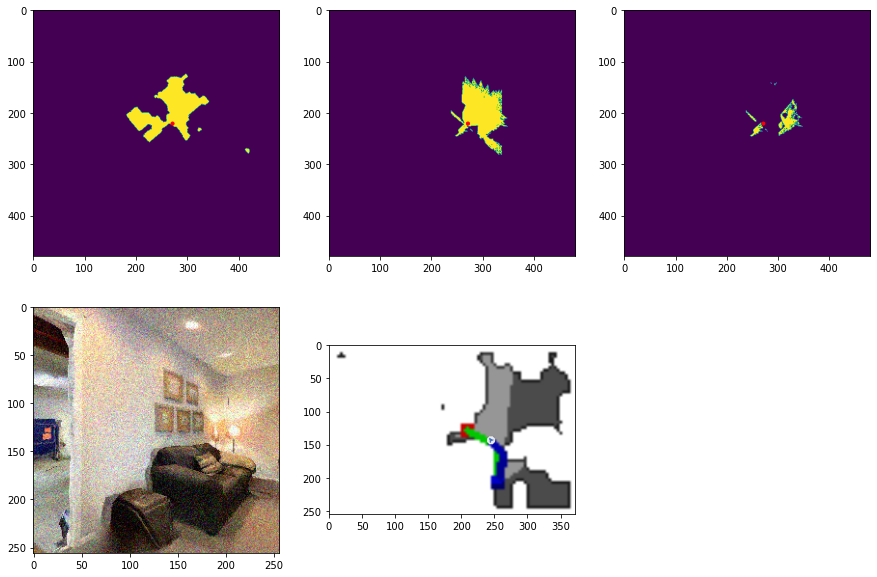

In [49]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
circ = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
circ2 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
circ3 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
ax.imshow(one_env.explorable_map)
ax.add_patch(circ)
ax2.imshow(one_env.explored_map)
ax2.add_patch(circ2)
ax3.imshow(one_env.map)
ax3.add_patch(circ3)
ax4.imshow(obs['rgb'])
top_down_map = draw_top_down_map(info, one_env.obs["heading"][0], obs['rgb'][0].shape[0])
ax5.imshow(top_down_map)
print(one_env.last_sim_location)
print([one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2,one_env.mapper_gt_pose[2]])